<a href="https://colab.research.google.com/github/gla-rik/classificationTagLanguage/blob/main/5dop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python.

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier.

In [29]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses


In [30]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset))

In [31]:
os.listdir(dataset_dir)

['.config',
 'stack_overflow_16k.tar.gz',
 'train',
 'test',
 'README.md',
 'sample_data']

In [32]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['java', 'csharp', 'python', 'javascript']

In [33]:
sample_file = os.path.join(train_dir, 'python/0.txt')
with open(sample_file) as f:
  print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

In [34]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    './train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [35]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print("Question", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

In [36]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])


Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [37]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    './train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [38]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    './test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [39]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [40]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [41]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [42]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [43]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

In [44]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [45]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [46]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [47]:
embedding_dim = 16

In [48]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),

  layers.Dense(4)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160084 (625.33 KB)
Trainable params: 160084 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [49]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [50]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/50
200/200 [==============================] - 3s 11ms/step - loss: 1.3779 - accuracy: 0.3352 - val_loss: 1.3662 - val_accuracy: 0.4769
Epoch 2/50
200/200 [==============================] - 1s 7ms/step - loss: 1.3496 - accuracy: 0.4409 - val_loss: 1.3293 - val_accuracy: 0.5106
Epoch 3/50
200/200 [==============================] - 1s 7ms/step - loss: 1.3024 - accuracy: 0.5267 - val_loss: 1.2736 - val_accuracy: 0.5956
Epoch 4/50
200/200 [==============================] - 2s 9ms/step - loss: 1.2369 - accuracy: 0.5917 - val_loss: 1.2025 - val_accuracy: 0.6381
Epoch 5/50
200/200 [==============================] - 2s 11ms/step - loss: 1.1596 - accuracy: 0.6402 - val_loss: 1.1272 - val_accuracy: 0.6700
Epoch 6/50
200/200 [==============================] - 1s 7ms/step - loss: 1.0823 - accuracy: 0.6750 - val_loss: 1.0552 - val_accuracy: 0.6956
Epoch 7/50
200/200 [==============================] - 1s 7ms/step - loss: 1.0109 - accuracy: 0.7023 - val_loss: 0.9900 - val_accuracy: 0.7131
Epoc

In [51]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 1s 5ms/step - loss: 0.5323 - accuracy: 0.8016
Loss:  0.5322745442390442
Accuracy:  0.8016250133514404


In [52]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

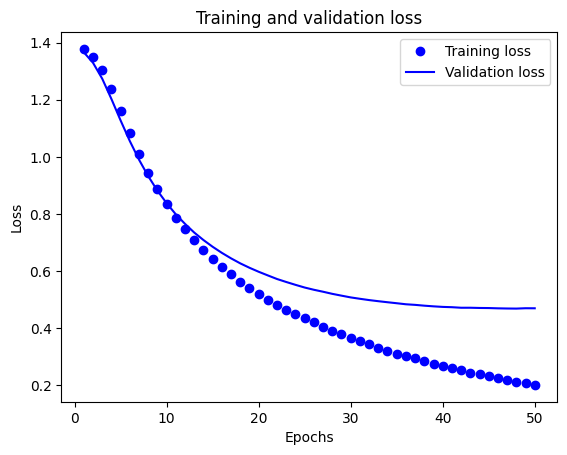

In [53]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

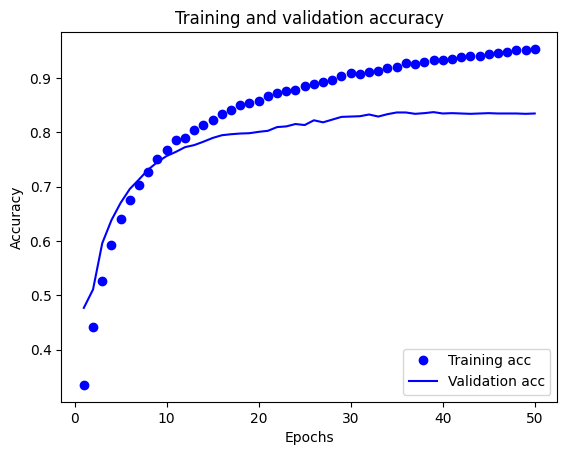

In [54]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [55]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 [==============================] - 2s 5ms/step - loss: 0.5323 - accuracy: 0.8016
0.8016250133514404


In [56]:
examples = [
    #python
  "Permission Denied when trying to edit the hosts file with a script in .ps1, in .py and in .bat. Hosts file with full permission to edit",
  "Pandas remove strings after character occurance",
#java
  "Spring java oauth2 authentication",
  "How to get ITypeBinding of HashMap in JDT without parsing code",
#javascript
  "react-testing-library test optimization - screen.findByText vs expect(screen.findByText).toBeInTheDocument()",
  "Query Selector doesn't get",
#c#
  "Publishing .NET 8 Razor Application to AWS Elastic Beanstalk",
  "Is Windows App SDK related/connected to UWP?"
]

result = export_model.predict(examples)
for i in range(len(result)):
  print(raw_train_ds.class_names[np.argmax(result[i])])

1/1 [==============================] - 0s 119ms/step
python
python
javascript
java
csharp
javascript
csharp
csharp


csharp || java || javascript || python